## Task 6: BERT fine-tuning for classification

**Team members:**
1. Jayanth varma Dantuluri: 225821 : jayanth.dantuluri@st.ovgu.de
2. Promod kumar Bontha: 226294 : pramod.bontha@st.ovgu.de


**What is the tutorial classifying when using the GLUE MRPC data set?**

It is a corpus of sentence pairs automatically extracted from online news sources. The label is whether the sentence pair is equivalent or not.

**In addition to the input itself, the tutorial feeds two binary tensors for input mask and input type to the model. Is this necessary for the data set single sentence classification?**

The input mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input word ids, and contains a 1 anywhere the input word ids is not padding.
The "input type" also has the same shape, but inside the non-padded region, contains a 0 or a 1 indicating which sentence the token is a part of.

**How does the tokenization in BERT differ from the one in the previous Task 5?**

During tokenization, if a word is combination of two words like for example 'tensorflow' is 'tensor' and 'flow'. It will split the word into two words with 2 hashes at the begining of the second word. 

**What is a [CLS] token and what is it used for?**

A CLS token indicates the start of the input sentence. So, the encoder can understand this is the start of the sentence.

**Which part of the BERT encoding is used for the classification?**
The bert encoder will generate the embedding for each word in the input sentence. These embeddings are fed as input to bert classifier(or any other classifier).

**Are the BERT encoder weights also fine-tuned to the task?**

No, because the bert encoder is already pre trained with large amount of text. so, that it understand the language. During the fine tuning process, the weights are only changed at the top layers where the classification happens. 

In [ ]:
pip install -q tf-nightly

In [ ]:
pip install -q tf-models-nightly

# Importing Libraries

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

## Getting the data from Tensorflow datasets

In [ ]:
glue, info = tfds.load('glue/cola', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteILQI6A/glue-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteILQI6A/glue-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteILQI6A/glue-test.tfrecord
Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/cola/1.0.0. Subsequent calls will reuse this data.


In [ ]:
list(glue.keys())

['test', 'train', 'validation']

In [ ]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})

In [ ]:
info.features['label'].names

['unacceptable', 'acceptable']

In [ ]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 1
sentence : b'It is this hat that it is certain that he was wearing.'


## Tokenize the input sentences using Bert tokenizer

In [ ]:
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

## Enconding the sentence

In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence"]])

In [ ]:
print("Sentence shape:", sentence.shape.as_list())

Sentence shape: [8551, None]


In [ ]:
sentence[0]

<tf.Tensor: shape=(14,), dtype=int32, numpy=
array([2009, 2003, 2023, 6045, 2008, 2009, 2003, 3056, 2008, 2002, 2001,
       4147, 1012,  102], dtype=int32)>

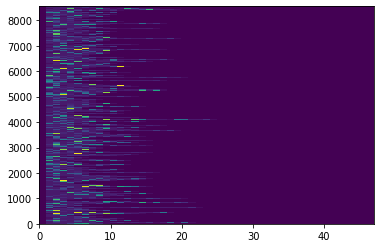

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]
input_word_ids = tf.concat([cls, sentence], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

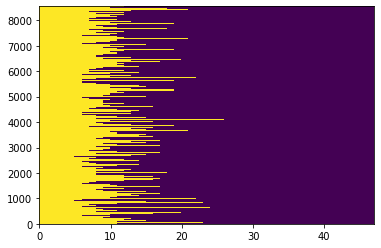

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

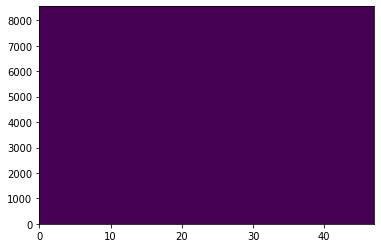

In [ ]:
type_cls = tf.zeros_like(cls)
type_s = tf.zeros_like(sentence)
input_type_ids = tf.concat([type_cls, type_s], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

## Putting it all together

In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence"])
  
  sentence = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]
  input_word_ids = tf.concat([cls, sentence], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s = tf.zeros_like(sentence)
  input_type_ids = tf.concat(
      [type_cls, type_s], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

## Splitting into Train and validataion sets

In [ ]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

In [ ]:
glue_train

{'input_mask': <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
 array([[ 101, 2009, 2003, ...,    0,    0,    0],
        [ 101, 2014, 8114, ...,    0,    0,    0],
        [ 101, 2119, 1996, ...,    0,    0,    0],
        ...,
        [ 101, 2198, 2246, ...,    0,    0,    0],
        [ 101, 2017, 2056, ...,    0,    0,    0],
        [ 101, 2054, 2057, ...,    0,    0,    0]], dtype=int32)>}

## Building the Model

In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

## Model Architecture

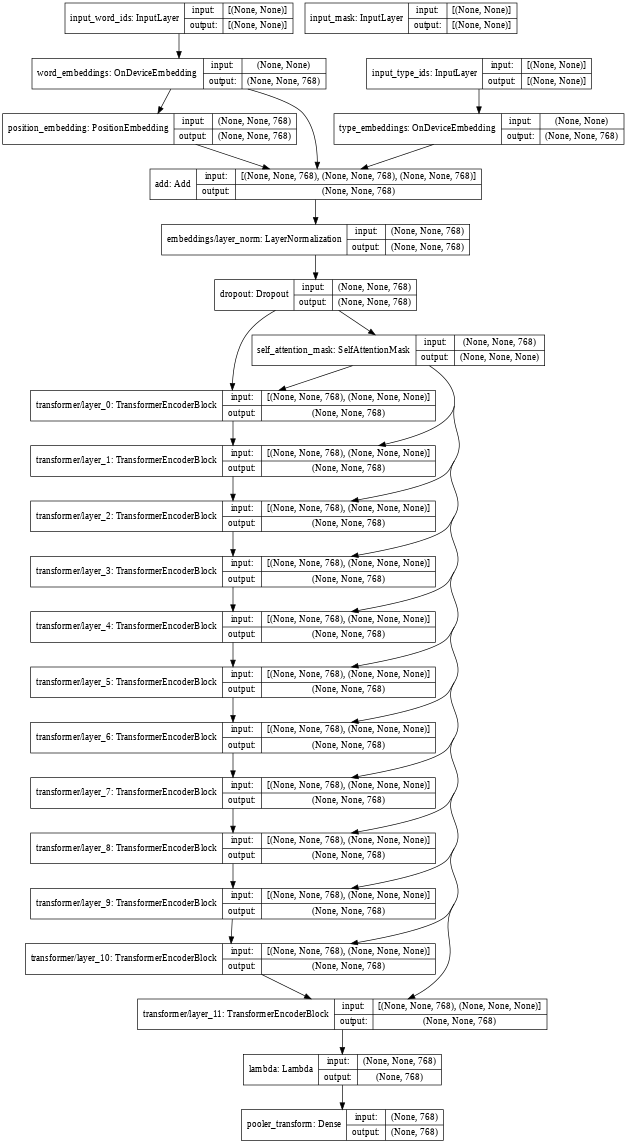

In [ ]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [ ]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

## Testing the bert encoder with 20 sentences from training data

In [ ]:
glue_batch = {key: val[:20] for key, val in glue_train.items()}
print(bert_encoder(glue_batch))

[<tf.Tensor: shape=(20, 1, 768), dtype=float32, numpy=
array([[[-0.46811232,  0.12466568, -0.3090288 , ..., -0.09195638,
          0.18098065,  0.33724126]],

       [[-0.30367583, -0.07194716, -0.09597226, ..., -0.03243611,
          0.15380663,  0.48674873]],

       [[-0.07534189,  0.00867537,  0.09219193, ..., -0.38102174,
          0.4592446 ,  0.30532697]],

       ...,

       [[ 0.03555591,  0.4009519 , -0.11255445, ...,  0.00952956,
          0.46256024,  0.07155412]],

       [[-0.283619  ,  0.3562356 , -0.6528807 , ..., -0.3969223 ,
          0.1921187 ,  0.02348027]],

       [[ 0.04382512,  0.2401722 , -0.02988797, ..., -0.02835641,
          0.09933546,  0.36110574]]], dtype=float32)>, <tf.Tensor: shape=(20, 768), dtype=float32, numpy=
array([[-0.82943326, -0.39025608, -0.8453315 , ..., -0.6568351 ,
        -0.7338067 ,  0.8679244 ],
       [-0.5491912 , -0.11231149, -0.03894949, ..., -0.279177  ,
        -0.4525063 ,  0.6305192 ],
       [-0.84930766, -0.32196096, -0.838

## Configuration for the classification Model

In [ ]:
transformer_config = config_dict.copy()

# You need to rename a few fields to make this work:
transformer_config['attention_dropout_rate'] = transformer_config.pop('attention_probs_dropout_prob')
transformer_config['activation'] = tf_utils.get_activation(transformer_config.pop('hidden_act'))
transformer_config['dropout_rate'] = transformer_config.pop('hidden_dropout_prob')
transformer_config['initializer'] = tf.keras.initializers.TruncatedNormal(
          stddev=transformer_config.pop('initializer_range'))
transformer_config['max_sequence_length'] = transformer_config.pop('max_position_embeddings')
transformer_config['num_layers'] = transformer_config.pop('num_hidden_layers')

transformer_config


{'activation': <function official.modeling.activations.gelu.gelu>,
 'attention_dropout_rate': 0.1,
 'dropout_rate': 0.1,
 'hidden_size': 768,
 'initializer': <tensorflow.python.keras.initializers.initializers_v2.TruncatedNormal at 0x7f1ec041a7f0>,
 'intermediate_size': 3072,
 'max_sequence_length': 512,
 'num_attention_heads': 12,
 'num_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

# Building the Bert Classifier

In [ ]:
manual_classifier = nlp.modeling.models.BertClassifier(
        bert_encoder,
        num_classes=2,
        dropout_rate=transformer_config['dropout_rate'],
        initializer=tf.keras.initializers.TruncatedNormal(
          stddev=bert_config.initializer_range))

In [ ]:
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


## Compiling the model

In [ ]:
manual_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

## Training and Testing the model

In [ ]:
manual_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
268/268 [==============================] - 2487s 9s/step - loss: 0.6046 - accuracy: 0.6605 - val_loss: 0.4546 - val_accuracy: 0.7910
Epoch 2/3
268/268 [==============================] - 2368s 9s/step - loss: 0.3460 - accuracy: 0.8586 - val_loss: 0.4520 - val_accuracy: 0.8226
Epoch 3/3
268/268 [==============================] - 2394s 9s/step - loss: 0.2301 - accuracy: 0.9176 - val_loss: 0.4943 - val_accuracy: 0.8274
